In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# 필요한 라이브러리 임포트
import numpy as np
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib
import sys
import random
from sklearn.model_selection import KFold

# 다시 임포트
from models_jh import CNN
from Segdataset_jh import SegDataset,read_train_file_list
from torch.utils.data import DataLoader

In [3]:
print(CNN)

<class 'models_jh.CNN'>


In [4]:
class Args:
    def __init__(self):
        self.data_root = '/workspace/dataset/CREMA-D/train'
        self.save_root = '/workspace/UndergraduateResearchAssistant/GraduateProject/code/CREMA-D/checkpoints_jh'
        self.epoch = 600
        self.lr = 1e-5
        self.batch_size = 64
        self.num_workers = 16
        self.random_seed = 1
        self.n_mfcc = 20
        self.n_splits = 5

opt = Args()


In [5]:
def main():
    print("Training by CNN")

    # 저장 디렉토리 없으면 생성
    if not os.path.exists(opt.save_root):
        os.makedirs(opt.save_root)
        print('Created directory:', opt.save_root)

    # 데이터셋 로딩
    mfcc_list, emotion_list = read_train_file_list(root=opt.data_root, n_mfcc=opt.n_mfcc)

    # KFold cross-validation
    kf = KFold(n_splits=opt.n_splits, shuffle=True, random_state=opt.random_seed)

    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')

    print(f"Using device: {device}")

    all_train_epoch_loss = []
    all_test_epoch_loss = []
    all_test_epoch_accuracy_emotion = []

    return kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [6]:
def train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion):
    patience = 15  # Early stopping을 위한 patience 설정 (10 에포크 동안 개선 없을 시 중단)
    for fold, (train_idx, val_idx) in enumerate(kf.split(mfcc_list)):
        print(f"Fold {fold + 1}/{opt.n_splits}")

        # 모델을 fold마다 초기화
        model = CNN().to(device)

        # 학습/검증 데이터로 쪼개기
        train_mfcc = [mfcc_list[i] for i in train_idx]
        train_emotion = [emotion_list[i] for i in train_idx]
        val_mfcc = [mfcc_list[i] for i in val_idx]
        val_emotion = [emotion_list[i] for i in val_idx]

        train_set = SegDataset(train_mfcc, train_emotion)
        val_set = SegDataset(val_mfcc, val_emotion)

        # Create dataloaders
        train_loader = DataLoader(train_set, batch_size=opt.batch_size, shuffle=True, drop_last=True, num_workers=opt.num_workers)
        val_loader = DataLoader(val_set, batch_size=opt.batch_size, shuffle=False, drop_last=True, num_workers=opt.num_workers)

        # 각 fold에 따라 pos_weight 동적으로 설정
        num_pos = sum(em == 1 for em in train_emotion)
        num_neg = sum(em == 0 for em in train_emotion)
        pos_weight = torch.tensor([num_neg / num_pos]).to(device) if num_pos > 0 else torch.tensor([1.0]).to(device)

        # loss and optimizer 선언
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight).to(device)
        optimizer = optim.Adam(model.parameters(), lr=opt.lr)

        # 현재 폴드 값들 저장
        train_losses = []
        val_losses = []
        val_accuracies = []

        best_val_loss = float('inf')
        best_epoch = 0
        early_stopping_counter = 0  # Early stopping을 위한 카운터

        for epo in range(opt.epoch):
            model.train()
            train_loss = 0

            for index, (mfcc, emotion) in enumerate(train_loader):
                mfcc, emotion = mfcc.to(device), emotion.to(device)
                optimizer.zero_grad()
                output_emotion = model(mfcc)

                emotion = emotion.float()
                loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            # 검증
            model.eval()
            val_loss = 0
            correct_emotion = 0
            total = 0
            with torch.no_grad():
                for mfcc, emotion in val_loader:
                    mfcc, emotion = mfcc.to(device), emotion.to(device)
                    output_emotion = model(mfcc)
                    emotion = emotion.float()

                    loss = criterion(output_emotion[:, 0].squeeze(), emotion)
                    val_loss += loss.item()

                    predicted_emotion = (torch.sigmoid(output_emotion[:, 0]) > 0.5).float()
                    correct_emotion += (predicted_emotion == emotion).sum().item()
                    total += emotion.size(0)

            val_accuracy = correct_emotion / total
            print(f"Fold {fold + 1} | Epoch {epo} | Train Loss: {train_loss / len(train_loader)} | Val Loss: {val_loss / len(val_loader)} | Val Accuracy: {val_accuracy}")

            # 모델 저장
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epo
                torch.save(model.state_dict(), os.path.join(opt.save_root, f'fold_{fold + 1}_best_epoch.pth'))
                early_stopping_counter = 0  # 검증 손실이 좋아졌으므로 카운터 초기화
            else:
                early_stopping_counter += 1  # 개선되지 않았으므로 카운터 증가

            # Early Stopping
            if early_stopping_counter >= patience:
                print(f"Early stopping at epoch {epo} for fold {fold + 1}")
                break

            # Track the training and validation losses and accuracies for plotting later
            train_losses.append(train_loss / len(train_loader))
            val_losses.append(val_loss / len(val_loader))
            val_accuracies.append(val_accuracy)

        print(f"Fold{fold+1} best epoch : {best_epoch} ")

        all_train_epoch_loss.append(train_losses)
        all_test_epoch_loss.append(val_losses)
        all_test_epoch_accuracy_emotion.append(val_accuracies)

        plot_fold_performance(train_losses, val_losses, val_accuracies, fold)

    return all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion


In [7]:
def plot_fold_performance(train_losses, val_losses, val_accuracies, fold):
    # Fold별로 그래프를 그리기 (Colab에서 바로 확인 가능하도록)
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'Fold {fold + 1} Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title(f'Fold {fold + 1} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


Training by CNN
Using device: cuda
Fold 1/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 1 | Epoch 0 | Train Loss: 0.43881130862880396 | Val Loss: 0.43692196905612946 | Val Accuracy: 0.5173611111111112
Fold 1 | Epoch 1 | Train Loss: 0.43387188057641723 | Val Loss: 0.43218694627285004 | Val Accuracy: 0.5243055555555556
Fold 1 | Epoch 2 | Train Loss: 0.42967414372676127 | Val Loss: 0.4275279806719886 | Val Accuracy: 0.5546875
Fold 1 | Epoch 3 | Train Loss: 0.4252900787301966 | Val Loss: 0.4227325982517666 | Val Accuracy: 0.5928819444444444
Fold 1 | Epoch 4 | Train Loss: 0.42137948846494827 | Val Loss: 0.41842666765054065 | Val Accuracy: 0.5980902777777778
Fold 1 | Epoch 5 | Train Loss: 0.417369703183303 | Val Loss: 0.4139502975675795 | Val Accuracy: 0.6215277777777778
Fold 1 | Epoch 6 | Train Loss: 0.41271525943601456 | Val Loss: 0.4096608344051573 | Val Accuracy: 0.6276041666666666
Fold 1 | Epoch 7 | Train Loss: 0.4088752112678579 | Val Loss: 0.40596915119224

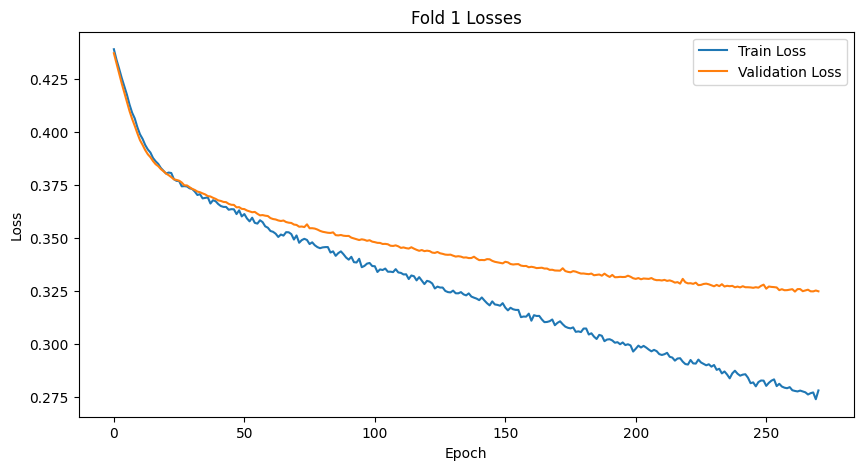

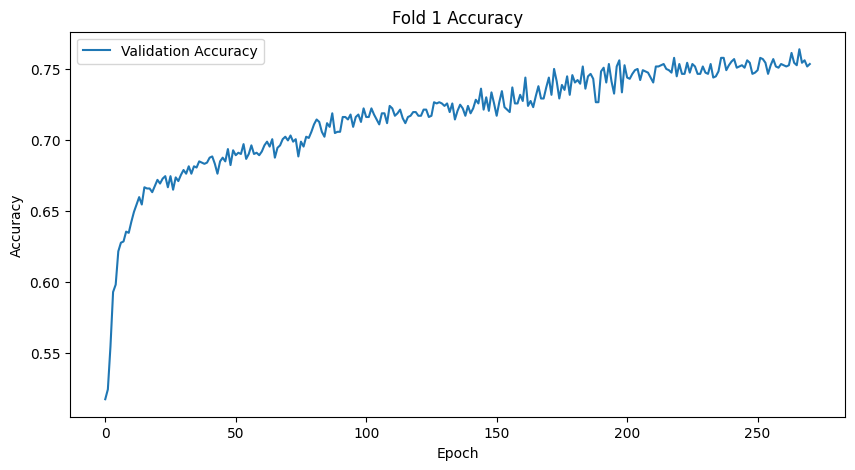

Fold 2/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 2 | Epoch 0 | Train Loss: 0.4397485558245633 | Val Loss: 0.43750250505076516 | Val Accuracy: 0.6171875
Fold 2 | Epoch 1 | Train Loss: 0.4337650287795711 | Val Loss: 0.4305708126889335 | Val Accuracy: 0.6328125
Fold 2 | Epoch 2 | Train Loss: 0.4283796798538517 | Val Loss: 0.42488432427247363 | Val Accuracy: 0.6354166666666666
Fold 2 | Epoch 3 | Train Loss: 0.4245792538733096 | Val Loss: 0.4198611941602495 | Val Accuracy: 0.6137152777777778
Fold 2 | Epoch 4 | Train Loss: 0.42038490925286265 | Val Loss: 0.4152394301361508 | Val Accuracy: 0.6215277777777778
Fold 2 | Epoch 5 | Train Loss: 0.4162449921305115 | Val Loss: 0.4108026574055354 | Val Accuracy: 0.6293402777777778
Fold 2 | Epoch 6 | Train Loss: 0.4124668059316841 | Val Loss: 0.40699880984094405 | Val Accuracy: 0.6510416666666666
Fold 2 | Epoch 7 | Train Loss: 0.40886920448896047 | Val Loss: 0.402941076291932 | Val Accuracy: 0.6432291666666666
Fold 2 | 

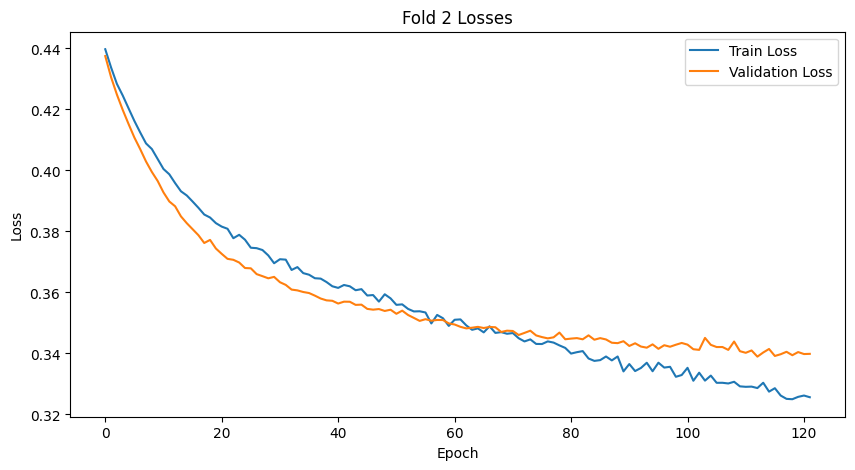

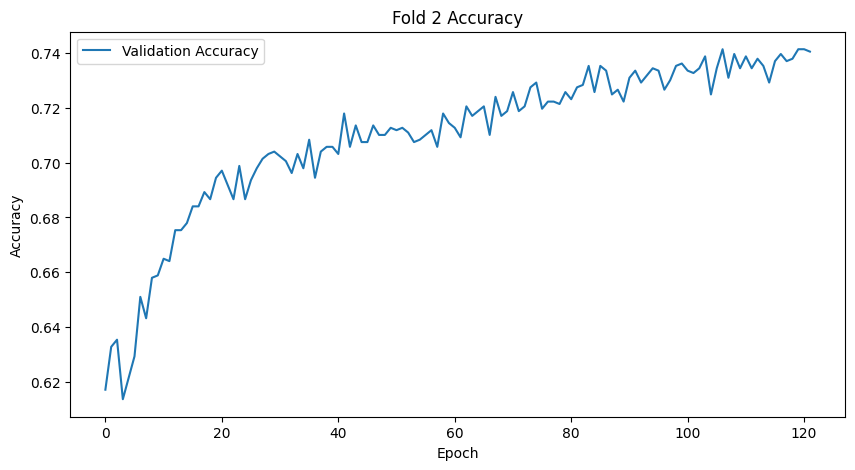

Fold 3/5
Dataset loaded with 4762 samples.
Dataset loaded with 1191 samples.
Fold 3 | Epoch 0 | Train Loss: 0.43531493842601776 | Val Loss: 0.43680556615193683 | Val Accuracy: 0.6215277777777778
Fold 3 | Epoch 1 | Train Loss: 0.43099343937796514 | Val Loss: 0.43252682354715133 | Val Accuracy: 0.625
Fold 3 | Epoch 2 | Train Loss: 0.42721660717113596 | Val Loss: 0.42840294871065354 | Val Accuracy: 0.6085069444444444
Fold 3 | Epoch 3 | Train Loss: 0.4236763196217047 | Val Loss: 0.424585501352946 | Val Accuracy: 0.609375
Fold 3 | Epoch 4 | Train Loss: 0.41996838877329956 | Val Loss: 0.4208504541052712 | Val Accuracy: 0.6154513888888888
Fold 3 | Epoch 5 | Train Loss: 0.4161687151000306 | Val Loss: 0.41755654248926377 | Val Accuracy: 0.6189236111111112
Fold 3 | Epoch 6 | Train Loss: 0.4129028251847705 | Val Loss: 0.4138675779104233 | Val Accuracy: 0.6284722222222222
Fold 3 | Epoch 7 | Train Loss: 0.4091963208204991 | Val Loss: 0.41091464625464547 | Val Accuracy: 0.625
Fold 3 | Epoch 8 | Trai

Exception ignored in: <function _releaseLock at 0x7f087b6b1c10>
Traceback (most recent call last):
  File "/opt/conda/envs/tess/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


Fold 3 | Epoch 53 | Train Loss: 0.3551789630909224 | Val Loss: 0.363988952504264 | Val Accuracy: 0.6996527777777778
Fold 3 | Epoch 54 | Train Loss: 0.3569792521161002 | Val Loss: 0.36353950533601975 | Val Accuracy: 0.7013888888888888
Fold 3 | Epoch 55 | Train Loss: 0.3541593902014397 | Val Loss: 0.3625743207004335 | Val Accuracy: 0.703125
Fold 3 | Epoch 56 | Train Loss: 0.35449528855246465 | Val Loss: 0.36355093618233997 | Val Accuracy: 0.6961805555555556
Fold 3 | Epoch 57 | Train Loss: 0.35496602871933497 | Val Loss: 0.36176584164301556 | Val Accuracy: 0.6987847222222222
Fold 3 | Epoch 58 | Train Loss: 0.35385794373782903 | Val Loss: 0.36120130121707916 | Val Accuracy: 0.7022569444444444
Fold 3 | Epoch 59 | Train Loss: 0.35185574760308136 | Val Loss: 0.3611341135369407 | Val Accuracy: 0.6979166666666666
Fold 3 | Epoch 60 | Train Loss: 0.3526874659834681 | Val Loss: 0.3600593043698205 | Val Accuracy: 0.6996527777777778
Fold 3 | Epoch 61 | Train Loss: 0.35183236929210454 | Val Loss: 0.3

In [8]:
if __name__ == '__main__':
    kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion = main()
    train_and_validate(kf, mfcc_list, emotion_list, device, all_train_epoch_loss, all_test_epoch_loss, all_test_epoch_accuracy_emotion)